In [1]:
#!/usr/bin/env python3

CONSIDER_FOURIER_VALUES = False
ONLY_LOAD_N_ROWS_FROM_DATASETS = None       # None to load all rows
SHAPLEY_KERNEL_EXPLAINER_SAMPLES = 200      # Default is 200
SHAPLEY_BEESWARM_EXPLAINER_SAMPLES = 1600   # Default is 1600
MAX_EVALS = 1200                            # Default is 1200
BEESWARM_MAX_DISPLAY = 40                   # Default is 40

NN_PATIENCE = 5                             # Default is 5
NN_NUM_EPOCHS = 50                          # Default is 200

import gc
import glob
import os
import random
import uuid
from typing import Dict, List, Tuple

print("import matplotlib")
import matplotlib.pyplot as plt
import copy

print("importing numpy and pandas")
import numpy as np
import pandas as pd
import tqdm

print("importing sklearn")
from loguru import logger
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

import rename_columns.rename as rename

print("all imports done...")
# import dotenv

# Way to dynamically change the number of jobs at run time
def get_num_jobs(default_jobs: int) -> int:
    """This function provides a way to override the number of jobs specified
    in the command line arguments dynamically.
    A file called num_jobs.txt can be created and the first line
    should contain the number of jobs.

    Args:
        default_jobs (int): default value if it is not overridden

    Returns:
        int: number of jobs to run
    """
    if not os.path.exists("num_jobs.txt"):
        return default_jobs
    with open("num_jobs.txt") as f:
        try:
            line = f.readlines()[0].strip()
            temp_jobs = int(line)
            if temp_jobs > 0 and temp_jobs < 20:
                logger.info(f"NUM_JOBS override: {temp_jobs}")
                return temp_jobs
        except:
            return default_jobs
    return default_jobs


def random_seed() -> None:
    np.random.seed(0)
    random.seed(0)


def get_save_filename() -> str:
    return f"{str(uuid.uuid4())}.csv.gz"


def gc_collect() -> None:
    for i in range(3):
        for j in range(3):
            gc.collect(j)


def get_columns_and_types(thisdf: pd.DataFrame) -> Dict[str, List[str]]:
    """For each feature set type, get the relevant columns.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        Dict[str, List[str]]: Dictionary that maps the feature type to the
            list of columns to the feature type.
    """
    columns = [c for c in thisdf.columns if not c.startswith("an_")]

    def get_columns(columns: List[str], start_string: str) -> List[str]:
        columns = [c for c in columns if c.startswith(start_string)]
        columns = [c for c in columns if "head" not in c and "tail" not in c]
        columns = [c for c in columns if "begin" not in c and "end" not in c]
        columns = [c for c in columns if "filesize" not in c]
        columns = [c for c in columns if "dit.shanon" not in c]
        
        # DO WE WANT RAW FOURIER VALUES
        if not CONSIDER_FOURIER_VALUES:
            columns = [c for c in columns if "fourier.value" not in c.lower()]
        
        return columns

    baseline_columns = get_columns(columns, "baseline")
    advanced_columns = get_columns(columns, "advanced")
    fourier_columns = get_columns(columns, "fourier")
    fourier_min_columns = [
        "fourier.stat.1byte.autocorr",
        "fourier.stat.1byte.mean",
        "fourier.stat.1byte.std",
        "fourier.stat.1byte.chisq",
        "fourier.stat.1byte.moment.2",
        "fourier.stat.1byte.moment.3",
        "fourier.stat.1byte.moment.4",
        "fourier.stat.1byte.moment.5",
    ]

    baseline_and_advanced = list(set(baseline_columns + advanced_columns))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns))
    advanced_and_fourier = list(set(advanced_columns + fourier_columns))
    baseline_and_fourier_min = list(set(baseline_columns + fourier_min_columns))
    advanced_and_fourier_min = list(set(advanced_columns + fourier_min_columns))

    baseline_advanced_fourier = list(
        set(baseline_columns + advanced_columns + fourier_columns)
    )
    baseline_advanced_and_fourier_min = list(
        set(baseline_columns + advanced_columns + fourier_min_columns)
    )

    rv = {
        "baseline-advanced-and-fourier": baseline_advanced_fourier,
    }

    #logger.info(f"Features = {rv}")

    return rv


def get_annotation_columns(thisdf: pd.DataFrame) -> List[str]:
    """List of columns used for annotation.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        _type_: List of columns
    """
    return [c for c in thisdf.columns if c.startswith("an_")]


def annotate_df_with_additional_fields(
    name: str, dataframe: pd.DataFrame
) -> pd.DataFrame:
    """Add some metadata to each dataframe

    Args:
        name (str): Name of the csv/parquet file
        dataframe (pd.DataFrame): Dataframe

    Returns:
        pd.DataFrame: Dataframe with additional information
    """
    if "base32" in name or "b32" in name:
        dataframe["an_is_base32"] = 1
    else:
        dataframe["an_is_base32"] = 0
    dataframe["an_is_base32"] = dataframe["an_is_base32"].astype(np.bool_)

    if "encrypt" in name:
        dataframe["is_encrypted"] = 1
    else:
        dataframe["is_encrypted"] = 0
    dataframe["is_encrypted"] = dataframe["is_encrypted"].astype(np.bool_)

    if "v1" in name:
        dataframe["an_v1_encrypted"] = 1
    else:
        dataframe["an_v1_encrypted"] = 0
    dataframe["an_v1_encrypted"] = dataframe["an_v1_encrypted"].astype(np.bool_)

    if "v2" in name:
        dataframe["an_v2_encrypted"] = 1
    else:
        dataframe["an_v2_encrypted"] = 0
    dataframe["an_v2_encrypted"] = dataframe["an_v2_encrypted"].astype(np.bool_)

    if "v3" in name:
        dataframe["an_v3_encrypted"] = 1
    else:
        dataframe["an_v3_encrypted"] = 0
    dataframe["an_v3_encrypted"] = dataframe["an_v3_encrypted"].astype(np.bool_)

    def is_webp(filename: str) -> int:
        return 1 if ".webp" in filename else 0

    dataframe["an_is_webp"] = (
        dataframe["extended.base_filename"].map(is_webp).astype(np.bool_)
    )

    return dataframe


def load_data(input_directory: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load all pandas data files from a directory and annotate them with
    additional fields

    Args:
        input_directory (str): input directory

    Returns:
        pd.DataFrame: A combined dataframe of all files (Train)
        pd.DataFrame: A combined dataframe of all files (Test)
    """

    interesting_files = [
        "plaintext.base32.combined.csv.gz",
        "expanded.base32.des3.csv.gz",
        "n1.plaintext.base32.csv.gz",
        "expanded_encrypted_v3.csv.gz",
        "n1.expanded.plaintext.csv.gz",
        "n1.expanded.pyencrypted_v2.csv.gz",
        "n1.expanded.pyencrypted_v1.base32.csv.gz",
        "expanded.des3.csv.gz",
        "n1.expanded.pyencrypted_v2.base32.csv.gz",
        "expanded.pyencrypted_v1.csv.gz",
        "expanded.pyencrypted_v2.base32.csv.gz",
        "expanded_encrypted_v3_base32.csv.gz",
        "n1.expanded.pyencrypted_v3.base32.csv.gz",
        "plaintext.combined.csv.gz",
        "plaintext.expanded.csv.gz",
        "expanded.pyencrypted_v2.csv.gz",
        "expanded.plaintext.base32.csv.gz",
        "n1.expanded.pyencrypted_v3.csv.gz",
        "n1.expanded.plaintext.base32.csv.gz",
        "n1.plaintext.csv.gz",
        "expanded.pyencrypted_v1.b32.csv.gz",
        "n1.expanded.pyencrypted_v1.csv.gz",
    ]
    p = 0.1
    logger.info("Loading dataframes")
    if ONLY_LOAD_N_ROWS_FROM_DATASETS and ONLY_LOAD_N_ROWS_FROM_DATASETS is not None:
        dataframes = {
            # f: pd.read_csv(f, skiprows=lambda i: i > 0 and random.random() > p)
            f: pd.read_csv(f, nrows=ONLY_LOAD_N_ROWS_FROM_DATASETS)
            for f in tqdm.tqdm(
                glob.glob(f"{input_directory}{os.path.sep}*.csv.gz"), desc="Loading data"
            )
            if os.path.basename(f).lower() in interesting_files
        }
    else:
        dataframes = {
            # f: pd.read_csv(f, skiprows=lambda i: i > 0 and random.random() > p)
            f: pd.read_csv(f)
            for f in tqdm.tqdm(
                glob.glob(f"{input_directory}{os.path.sep}*.csv.gz"), desc="Loading data"
            )
            if os.path.basename(f).lower() in interesting_files
        }

    logger.info("Annotating dataframes with additional fields")
    dataframes = {
        f: annotate_df_with_additional_fields(f, df) for f, df in dataframes.items()
    }

    logger.info("Combining test dataframes into a single dataframe")
    test_df = (
        pd.concat([df for fname, df in dataframes.items() if "n1." in fname.lower()])
        .sample(frac=1)
        .reset_index(drop=True)
    )

    logger.info("Combining train dataframes into a single dataframe")
    train_df = (
        pd.concat(
            [df for fname, df in dataframes.items() if "n1." not in fname.lower()]
        )
        .sample(frac=1)
        .reset_index(drop=True)
    )

    
    logger.info("done...")
    return train_df, test_df
  

import matplotlib
importing numpy and pandas
importing sklearn
all imports done...


In [2]:
master_train_df, master_test_df = load_data("/Users/phantom/dev/NapierOne")

2023-07-21 15:59:19.588 | INFO     | __main__:load_data:245 - Loading dataframes
Loading data:   9%|██████████▊                                                                                                       | 5/53 [00:32<05:01,  6.28s/it]

KeyboardInterrupt: 

In [ ]:
annot_columns = get_annotation_columns(master_train_df)
fscolumns = get_columns_and_types(master_train_df)["baseline-advanced-and-fourier"]
colnames = [c for c in fscolumns if "is_encrypted" not in c]
colnames = [c for c in colnames if c not in annot_columns]
colnames = [c for c in colnames if not c.startswith("an_")]
colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
            
            
train_df=master_train_df[colnames + ["is_encrypted"]].copy()
test_df=master_test_df[colnames + ["is_encrypted"]].copy()
            
            
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = train_df[colnames]
y_train = train_df["is_encrypted"].to_numpy().flatten()
X_test = test_df[colnames]
y_test = test_df["is_encrypted"].to_numpy().flatten()
            
gc_collect()        
print("Creating NN MODEL")
pline = pipeline.Pipeline(
    [
        ('std', MinMaxScaler()),
        ('classif', RandomForestClassifier(n_jobs=8))
    ]
)
print("Fitting Random Forest")
pline.fit(X_train, y_train)

Creating NN MODEL
Fitting Random Forest


Pipeline(steps=[('std', MinMaxScaler()),
                ('classif', RandomForestClassifier(n_jobs=8))])

Text(0.5, 0, 'Importance')

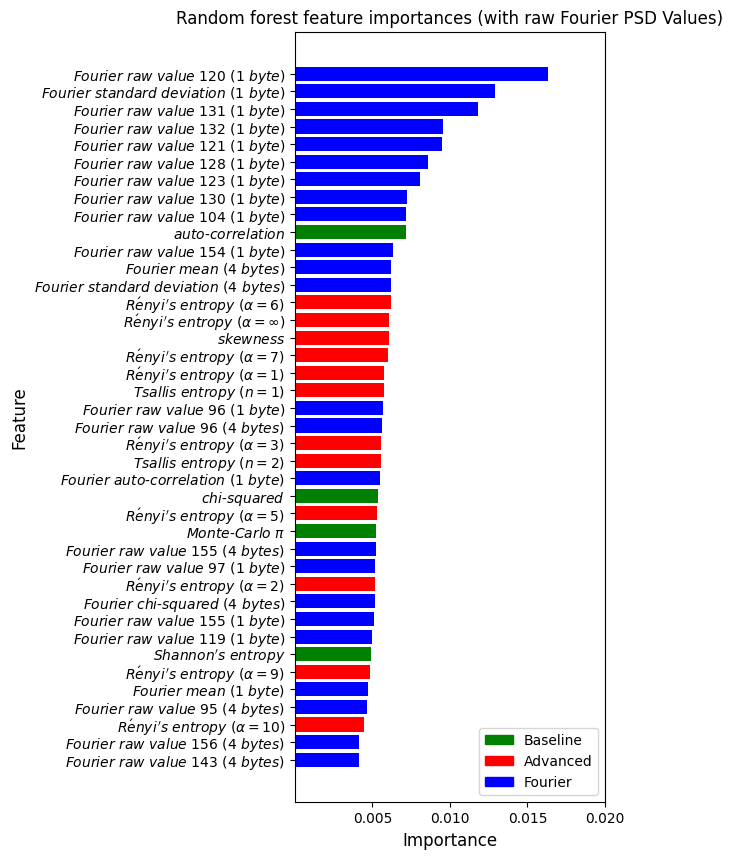

In [ ]:
def get_color(colname: str) -> str:
    colname = colname.lower()
    if colname.startswith("baseline"):
        return "green"
    elif colname.startswith("fourier"):
        return "blue"
    else:
        return "red"

feature_importances = pline.named_steps['classif'].feature_importances_
importance_df = pd.DataFrame(
    {
        "original_feature_name": colnames,
        "features": [rename.rename_column(c) for c in colnames],
        "importances": feature_importances,
        "colors": [get_color(c) for c in colnames]
    }
)

importance_df = importance_df.sort_values(by="importances", ascending=False).reset_index(drop=True)

plt_df = importance_df.head(BEESWARM_MAX_DISPLAY)

fig, ax = plt.subplots((1), figsize=(4, 10))
ax.barh(
    plt_df["features"],
    plt_df["importances"],
    color=plt_df["colors"],
)

ax.invert_yaxis()
legend_handles = [
                  plt.Rectangle((0, 0), 1, 1, color='blue'),
                  plt.Rectangle((0, 0), 1, 1, color='red'),
                  plt.Rectangle((0, 0), 1, 1, color='green')
                  ][::-1]
ax.legend(legend_handles, ["Fourier", "Advanced", "Baseline"][::-1])
ax.set_title("Random forest feature importances (with raw Fourier PSD Values)")
ax.set_xticks([0.005, 0.010, 0.015, 0.020])
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature", fontsize=12)
ax.set_xlabel("Importance", fontsize=12)

Text(0.5, 0, 'Importance')

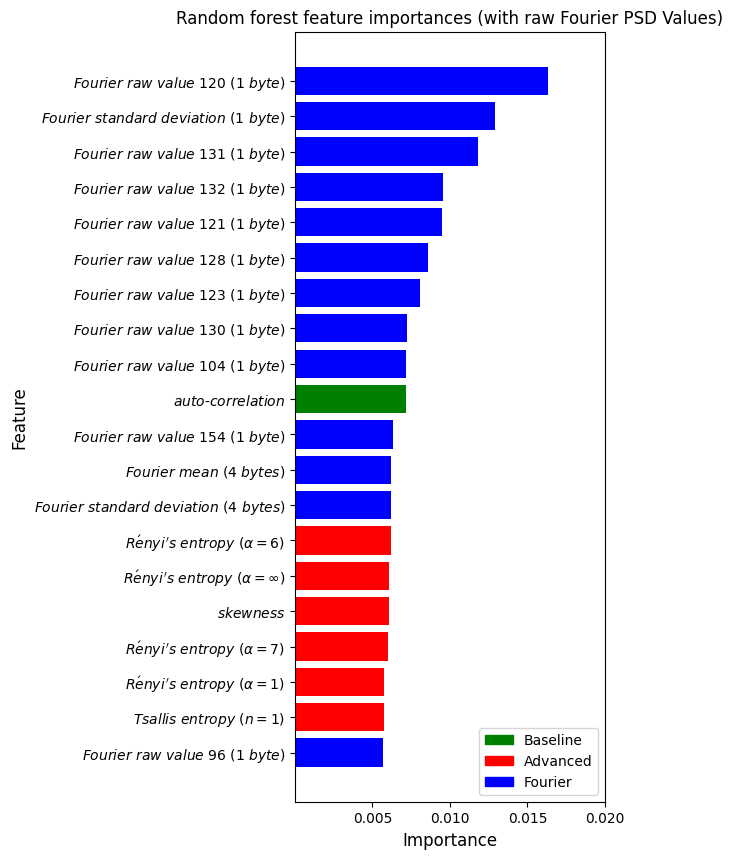

In [ ]:
plt_df = importance_df.head(20)


fig, ax = plt.subplots((1), figsize=(4, 10))
ax.barh(
    plt_df["features"],
    plt_df["importances"],
    color=plt_df["colors"],
)

ax.invert_yaxis()
legend_handles = [
                  plt.Rectangle((0, 0), 1, 1, color='blue'),
                  plt.Rectangle((0, 0), 1, 1, color='red'),
                  plt.Rectangle((0, 0), 1, 1, color='green')
                  ][::-1]
ax.legend(legend_handles, ["Fourier", "Advanced", "Baseline"][::-1])
ax.set_title("Random forest feature importances (with raw Fourier PSD Values)")
ax.set_xticks([0.005, 0.010, 0.015, 0.020])
ax.set_ylabel("Feature", fontsize=12)
ax.set_xlabel("Importance", fontsize=12)

In [ ]:
importance_df.to_csv("rf-importances-no-raw-raw-values.csv")